# Recovering images with a variational network

The goal of this homework is to implement a variational network that recovers CT images from few measurements. Training a variational network is time intensive, therefore we work with a few images only, and use a small network with only 2 layers per iteration/cascade. This setup save us computational time relative to working with real-world large datasets arising in practical applications.

Most of the implementation is set up already, your task is to implement the variational network and run the code. The training and reconstructing functions are provided, feel free to modify them or use your own functions.

In [ ]:
from google.colab import drive
import os

gdrive_path = '/content/gdrive/MyDrive/Colab Notebooks/dlip/HW6/'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
print(sorted(os.listdir()))

Mounted at /content/gdrive
['VarNet_problem.ipynb', '__MACOSX', '__pycache__', 'data', 'radon.py']


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.fft

from radon import get_operators

In [ ]:
data_path = gdrive_path + "./data/"  ####enter your data path here

In [ ]:
device = 'cuda' #'cuda' for GPU, 'cpu' otherwise
img = torch.load(data_path + '0')
print(img.shape)  # (1, 256, 256)

torch.Size([1, 256, 256])


### We consider reconstruction from 8x undersampled random measurements

In [ ]:
a = img.shape[-1]
f = 8 #undersampling factor
radon_op, fbp_op = get_operators(n_angles=a//f, image_size=a, circle=True, device=device)

#forward model representing a radon transform
def A(x):
    y = radon_op(x)
    return y

#We use filtered back projection as an estimate of A.T
def AT(y):
    x = fbp_op(y)
    x = x.to(torch.float32)
    return x

In [ ]:
##Prepare data
class data():
    
    def __init__(self, path):
        self.path = path

    def __len__(self):
        return len(os.listdir(self.path))
    
    def __getitem__(self, idx):
        
        data=torch.load(self.path+str(idx)).to(device)

        return data

In [ ]:
data_set = data(data_path)

#Split dataset into 99 imgs for training and 1 img for validation
train_set, val_set = torch.utils.data.random_split(data_set, [99, 1], generator=torch.Generator().manual_seed(0))

#Dataloader
train_dl = DataLoader(train_set, batch_size=1)
val_dl = DataLoader(val_set, batch_size=1)

# Variational network

The task is to implement a variational network in the cell below. The network consists of num_cascades = 5, i.e., has 5 iterations. The network should output the reconstruction after every cascade (see last cell).

The network is initialized as 
$$
x^t = A^T y,
$$
and implements the iterations
$$
x^{t+1} = x^t - \eta (A^T(Ax^t -y) + R_t(x^t)),
$$
where $R_t$ is a regularizer parameterized as
$$
R_t(x) = \sum_{i=1}^k C_{t,1,i}^T relu(C_{t,2,i} x).
$$
Here, $C_{t,j,i}$ is a convolution with a kernel of size $3\times 3$. Note that the regularizer is a simple convolutional network that can be implemented with the functions nn.Conv2d() and nn.ReLU(). In summary the regularizer can be thought of as a 2 layer CNN with $k$ filters and ReLU activation function.

The parameter $\eta$ is a trainable parameter, initialize it to $\eta=0.01$.

In [ ]:
# fill in code here

# you are free to create as many classes as you need



#Whole Variational Network    
class VarNet(nn.Module):
    def __init__(self, num_cascades=5):
        super(VarNet, self).__init__()
        
        # fill in code here
        self.num_cascades = num_cascades
        self.lr = 0.01
        self.in_channel = 1
        self.out_channel = 1
        self.hidden_channel = 16

        self.cnn_model = nn.Sequential(
            nn.Conv2d(in_channels=self.in_channel,
                      out_channels=self.hidden_channel,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=self.hidden_channel,
                      out_channels=self.out_channel,
                      kernel_size=3,
                      stride=1,
                      padding=1),
        )
        
    def forward(self, y):
        
        # fill in code here
        # y.shape: (1, 1, 256, 32)
        # x.shape: (1, 1, 256, 256)
        x = AT(y)

        x_pred = []
        for _ in range(self.num_cascades):
            cnn = self.cnn_model(x)
            x = x - self.data_consistency(x, y) + cnn
            x_pred.append(x) 
         
        return x_pred

    def data_consistency(self, x, y):
        return self.lr * AT(A(x) - y)

In [ ]:
model = VarNet()
model = model.to(device)

### Below are funtions to train and test the network

You can modify the functions or the hyperparameters for training as you wish

In [ ]:
##Loss
def mse(gt: torch.Tensor, pred:torch.Tensor)-> torch.Tensor:
    loss = torch.nn.MSELoss()
    return loss(gt, pred)

#train function
def train(model, optimizer, sample):
    model.train()
    
    # reset optimizer's gradient
    optimizer.zero_grad()

    # define variables
    x = sample
    y = A(x)
      
    # get the prediction
    pred = model(y)[-1]
    pred_loss = mse(pred, x)
    
    # one step of training
    pred_loss.backward()
    optimizer.step()

    return pred_loss.item()

#test function
def test(model, sample): 
    model.eval()
    
    with torch.no_grad(): 
        
        x = sample
        y = A(x)
        
        # get the prediction
        pred = model(y)[-1]
        pred_loss = mse(pred, x)

    return pred_loss.item()

#reconstruction
def inference(model, sample): 
    model.eval()
    
    with torch.no_grad(): 
        
        x = sample
        y = A(x)
        pred = model(y)

    return pred

### Training

As optimizer, we choose the Adam optimizer (a standard adaptive gradient method). We then train the model for 10 epochs; training for more epochs gives better results, but after 10 epochs we already get a model that works reasonably well for image recovery.

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0)

max_epoch = 80
mse_train=[]
mse_val= []

for epoch in tqdm(range(max_epoch)):
    # Initialize Loss and Accuracy
    train_loss = val_loss= 0.0
    
    ### Training Phase
    
    ## Iterate over the train_dataloader
    with tqdm(total=len(train_dl)) as pbar:
        for sample in train_dl:            
            curr_loss = train(model, optimizer, sample)
            train_loss += curr_loss / len(train_dl) 
            pbar.update(1)
    
    mse_train.append(train_loss)


    ### Validation Phase 
    
    ## Validation_dataloader
    with tqdm(total=len(val_dl)) as pbar:
        for sample in val_dl: 
            curr_loss= test(model, sample)
            val_loss += curr_loss / len(val_dl)
            pbar.update(1)
    
    mse_val.append(val_loss) 
    
    print(epoch, train_loss, val_loss)    


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0 0.032083456771391815 0.005331890657544136


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

1 0.003568133186417245 0.002495433669537306


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

2 0.0017387206334564264 0.0012363039422780275


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

3 0.0010135974887890197 0.0008624016190879047


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

4 0.0007438174892226327 0.0006682868115603924


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

5 0.0005979650472220259 0.0005601296434178948


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

6 0.0005177268793693545 0.0004987274296581745


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

7 0.0004715515656932961 0.0004617337544914335


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

8 0.00044368497081891166 0.0004342201864346862


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

9 0.0004271731389724094 0.00041927219717763364


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

10 0.00040748801712661676 0.00039862049743533134


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

11 0.00039175173268898026 0.0003853877424262464


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

12 0.00037981770186558015 0.0003744207206182182


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

13 0.000369954867478968 0.0003649478021543473


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

14 0.00036163710826782135 0.00035666688927449286


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

15 0.00035454895487878335 0.00034936435986310244


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

16 0.0003484476694597327 0.00034286262234672904


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

17 0.0003431696410060418 0.0003370274789631367


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

18 0.0003385603023079142 0.00033179554156959057


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

19 0.00033447580312665636 0.0003271415480412543


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

20 0.0003307873174145987 0.00032305519562214613


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

21 0.00032744084080949307 0.0003196096804458648


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

22 0.00032434416047033993 0.0003167723771184683


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

23 0.00032148610405398126 0.00031444168416783214


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

24 0.000318866641427663 0.00031234617927111685


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

25 0.00031645656983730295 0.0003101565525867045


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

26 0.0003142352320307941 0.0003075574350077659


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

27 0.00031212691351126964 0.0003043891629204154


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

28 0.00031005093463898803 0.0003007067716680467


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

29 0.00030790673006758694 0.000296659825835377


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

30 0.0003056266473552136 0.0002924922155216336


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

31 0.00030309538565096296 0.00028851244132965803


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

32 0.00030025329077475226 0.00028493127319961786


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

33 0.0002970734337460003 0.00028189923614263535


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

34 0.0002935771457615751 0.0002793410385493189


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

35 0.000289945102666006 0.0002771083964034915


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

36 0.0002864224103048933 0.00027529234648682177


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

37 0.0002832011100095273 0.00027399271493777633


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

38 0.00028027578596862945 0.0002727624378167093


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

39 0.000277575794807306 0.00027082717861048877


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

40 0.0002751041480370638 0.0002681927289813757


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

41 0.00027293800314620256 0.0002653618576005101


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

42 0.00027110380390447307 0.0002627742651384324


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

43 0.00026957975168985244 0.00026059194351546466


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

44 0.00026830819063829343 0.000258826301433146


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

45 0.00026722424463698226 0.0002573616220615804


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

46 0.0002661703315838662 0.0002560850407462567


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

47 0.00026515333835656435 0.00025506637757644057


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

48 0.00026422152851327246 0.00025419442681595683


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

49 0.0002633031487648347 0.00025332486256957054


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

50 0.00026238143515791947 0.0002523534931242466


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

51 0.0002614371166940816 0.00025128095876425505


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

52 0.0002605023969822055 0.00025012381956912577


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

53 0.00025955735658168464 0.00024888708139769733


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

54 0.00025864335063920183 0.000247611606027931


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

55 0.0002577270694533268 0.00024628773098811507


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

56 0.0002568088765279626 0.00024489613133482635


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

57 0.0002558840371990538 0.00024345448764506727


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

58 0.00025496250409468284 0.00024198087339755148


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

59 0.00025401203994547506 0.000240469365962781


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

60 0.0002530397020628433 0.00023896610946394503


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

61 0.00025206136269109193 0.00023749169486109167


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

62 0.000251072470608492 0.00023608244373463094


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

63 0.0002500929891318788 0.0002347190020373091


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

64 0.00024910551946224515 0.00023342148051597178


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

65 0.0002481452269641909 0.00023217398847918957


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

66 0.0002471916184988757 0.00023100708494894207


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

67 0.00024625894222867135 0.00022986458498053253


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

68 0.00024533243141386363 0.00022879362222738564


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

69 0.00024443355012941415 0.00022776539844926447


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

70 0.00024355585966729604 0.00022678766981698573


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

71 0.0002427071990266517 0.00022585414990317076


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

72 0.00024188553961170282 0.000224952949793078


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

73 0.00024108757938709903 0.00022409073426388204


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

74 0.00024029977514991778 0.00022324988094624132


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

75 0.00023953498028350448 0.00022240888210944831


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

76 0.00023878234670252896 0.00022158827050589025


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

77 0.00023804015904486253 0.00022078529582358897


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

78 0.0002372974200312971 0.00021997808653395623


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

79 0.00023656215996721366 0.00021919459686614573


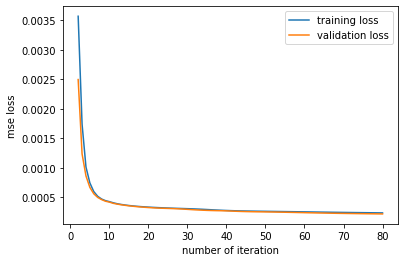

In [ ]:
plt.plot(range(2, max_epoch + 1), mse_train[1:])
plt.plot(range(2, max_epoch + 1), mse_val[1:])
plt.xlabel('number of iteration')
plt.ylabel('mse loss')
plt.legend(['training loss', 'validation loss'])
plt.show()

### Visualization how VarNet reconstructs an image

Text(0.5, 1.0, 'Ground Truth')

<Figure size 432x288 with 0 Axes>

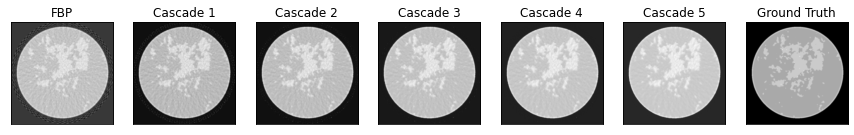

In [ ]:
sample = next(iter(val_dl))  #img from val set
pred = inference(model, sample) #reconstruct val img

plt.gray()
fig, ax = plt.subplots(1, 7,figsize=(15, 15))

ax[0].imshow(AT(A(sample)).squeeze(0).squeeze(0).cpu())   
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('FBP') # Filtered back projection  

for i in range(5):
    ax[i+1].imshow(pred[i].squeeze(0).squeeze(0).cpu())
    ax[i+1].set_xticks([])
    ax[i+1].set_yticks([])
    ax[i+1].set_title('Cascade '+ str(i+1))
    
ax[6].imshow(sample.squeeze(0).squeeze(0).cpu())   
ax[6].set_xticks([])
ax[6].set_yticks([])
ax[6].set_title('Ground Truth')  